In [1]:
import os
import pytorch_lightning as pl
from argparse import ArgumentParser
from uuid import uuid4
import torch as ch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os import path

import numpy as np
import torch as ch
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
import scipy.stats as stats



In [2]:
def plot_genes(labels_data0, yhat_data0, cmap, index):
  
    all_d = pd.concat([pd.DataFrame(labels_data0), pd.DataFrame(yhat_data0[:,index])], axis = 1)
    all_d.columns = ['x', 'y','z','feature'+str(index)]

    
    g = sns.scatterplot(data = all_d, x = 'x', y = 'y', hue = 'feature'+str(index),palette= cmap)
    
    return g

def load_data(data_dir, prefix="Cell"):
        #expr = pd.read_csv(os.path.join(data_dir, "data_table.csv"), index_col=0)
    expr = pd.read_csv(os.path.join(data_dir, "cell_barcode_count.csv"), header=None)
    gene_names = pd.read_csv(os.path.join(data_dir, "cell_barcode_names.csv"),header=None)
    rownames = [i for i in range(expr.shape[0])]
    names = gene_names[2]
    names.name = "Gene"
    return pd.DataFrame(data=expr.values, columns=names, index=rownames)



In [3]:
import sys
sys.path.append('/Users/work/Documents/GitHub')

from mlgenomics.djuna_models.MatrixFNN_Djuna import SimpleFNN

In [4]:
# load the model (change the directory to point to your location of mlgenomics)
PATH = '/Users/work/Documents/GitHub/mlgenomics/djuna_models/lightning_logs/version_1_Wang_2018_all_2D_3D_processed_new_0_1_leftout/checkpoints/epoch=392-v0.ckpt'
new_model_unseen = SimpleFNN.load_from_checkpoint(checkpoint_path=PATH)
new_model_unseen.eval()

"lr": 0.001


SimpleFNN(
  (layers): Sequential(
    (0): Linear(in_features=1030, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [5]:
# select dataset of interest

direct_leftout = '/Users/work/Documents/GitHub/mlgenomics/data_preprocessing/Wang_2018_all_2D_3D_processed_new.npz'
content_leftout = np.load(direct_leftout)['arr_0']
unseen_0 = content_leftout[content_leftout[:,-1]==0,] # selecting features corresponding to dataset 1

# col 0 to 1029 correspond to features
# col 1030-32 correspond to x,y,z (for 2D data, z = 0)
# col 1033 corresponds to the dataset annotation 
# where the order 0-9 corresponds to the datasets listed in the order below (ie 20180505_BY3_1kgenes = dataset1)
# the 3D dataset is dataset 10
dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

# set dirs equal to if not djuna's laptop 

In [6]:
# get elements of the dataset and store as tensor

data_unseen = ch.from_numpy(unseen_0[:, :-4]).float()
# @Fatima: you can use the code in the previous code chunk to load the data you want to analyze, @Na: you would
# need to replace 'unseen_0' with the single-cell counts

coordinates_unseen = ch.from_numpy(unseen_0[:, -4:-1]).float()
dataindex_unseen = ch.from_numpy(unseen_0[:,-1]).float() 
full_dataset_unseen  = TensorDataset(data_unseen , coordinates_unseen , dataindex_unseen )

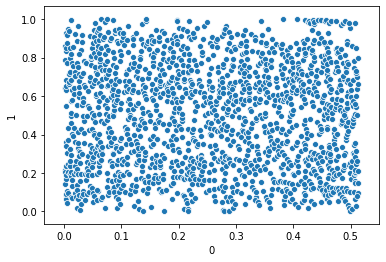

In [7]:
plot = pd.DataFrame(coordinates_unseen.detach().numpy())
sns.scatterplot(data = plot, x = 0, y = 1)

In [8]:
# use error function from model to compute the error
def compute_matrix(x): # compute pairwise distances for input matrix 
    x = x[:, None, :] - x[None, :, :]
    x = (x ** 2).mean(2)


    return x 

def compute_loss(y, y_hat):
    true_matrix = compute_matrix(y)
    pred_matrix = compute_matrix(y_hat)
    loss = np.absolute((true_matrix - pred_matrix))    
    return loss

In [208]:
yhat_dist = compute_matrix(yhat)
actual_dist = compute_matrix(label)

yhat_dist_extr = yhat_dist[np.triu_indices(yhat_dist.shape[0], k=1, m=None)]
actual_dist_extr = actual_dist[np.triu_indices(actual_dist.shape[0], k=1, m=None)]

In [209]:
len(yhat_dist_extr) == len(actual_dist_extr)

True

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


(8.917844e-05, 0.34806824)

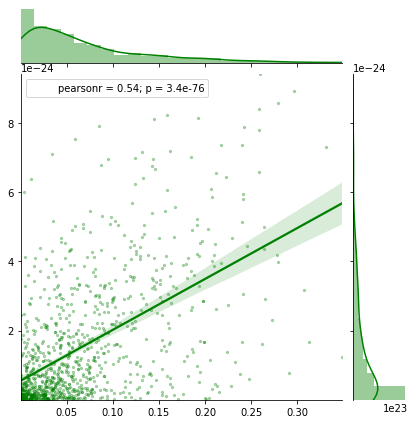

In [229]:
index = np.random.choice(range(len(unique_yhat_dist)), size=1000, replace=False)
sns.jointplot(x = actual_dist_extr[index], y = yhat_dist_extr[index], kind = 'reg', stat_func=stat.pearsonr, scatter_kws = {'alpha':0.3, 's':5}, color = 'green')


plt.ylim(yhat_dist_extr[index].min(), yhat_dist_extr[index].max())
plt.xlim(actual_dist_extr[index].min(), actual_dist_extr[index].max())

In [235]:
yhat_dist.max()

1.510615e-23

In [237]:
yhat

array([[-1.8223630e-12, -1.2349693e-12,  9.4334826e-13],
       [-2.2652882e-12, -1.1091009e-12,  1.5388080e-12],
       [ 1.3366726e-14, -1.9964306e-12, -1.7250233e-12],
       ...,
       [-1.3872125e-12, -4.9400230e-13,  1.1005712e-12],
       [-4.9388049e-13, -2.0347339e-12, -1.2006805e-12],
       [-5.3815183e-13, -6.4221144e-13,  4.0228946e-14]], dtype=float32)

In [9]:
# run the model on the dataset 

# (you cann modify the for loop to include only the outputs you need (i.e. teh model predictions, out))

out = []
index = []
label = []
feature = []
for features, labels, dataset_idx in (iter(DataLoader(full_dataset_unseen))):
    label.append(labels.detach().numpy())
    index.append(dataset_idx.detach().numpy())
    feature.append(features.detach().numpy())
    out.append((new_model_unseen(features, dataset_idx)).detach().numpy())


In [10]:
# concatenate the output 

yhat = np.concatenate(out) # yhat corresponds to the model prediction (this is what you'll be interested in)
idx = np.concatenate(index)
label = np.concatenate(label) # corresponds to the actual coordinates
features = np.concatenate(feature) # corresponds to the input features

In [12]:
# add pairwise distance error plots (i.e. loss that the model is trying to minimize)

# cluster on yhat predictions 


In [27]:
label

array([[0.00144301, 0.14138848, 0.        ],
       [0.00201393, 0.21509698, 0.        ],
       [0.00193673, 0.2032011 , 0.        ],
       ...,
       [0.5128923 , 0.21204081, 0.        ],
       [0.51216084, 0.66401875, 0.        ],
       [0.512105  , 0.7962725 , 0.        ]], dtype=float32)

[(0, 1)]

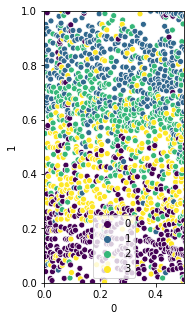

In [36]:
# color cells according to clusters 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(yhat)

# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))

g = sns.scatterplot(data = pd.DataFrame(label), x = 0, y = 1, hue = kmeans.labels_, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

In [40]:
yhat[:,0].reshape(-1,1)

array([[-1.8223630e-12],
       [-2.2652882e-12],
       [ 1.3366726e-14],
       ...,
       [-1.3872125e-12],
       [-4.9388049e-13],
       [-5.3815183e-13]], dtype=float32)

[(0, 1)]

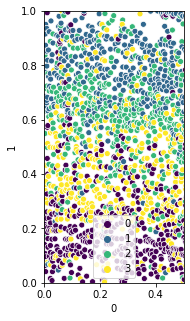

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(yhat[:,2].reshape(-1,1))

# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))

g = sns.scatterplot(data = pd.DataFrame(label), x = 0, y = 1, hue = kmeans.labels_, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

In [23]:
# color cells according to clusters 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(yhat)

# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))

g = sns.scatterplot(data = pd.DataFrame(label), x = 0, y = 1, hue = kmeans.labels_, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

1549

[(0, 1)]

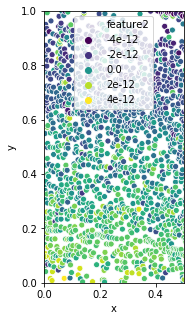

In [38]:
# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))

g = plot_genes(label, yhat, 'viridis', 2)
#plt.legend([],[], frameon=False)
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

In [40]:
# get gene annotations: all_genes correspond to the column labels from column 0 to column N (where N = len(all_genes))
# in Wang_2018_all_2D_3D_processed_new

genenames_3D = pd.read_csv('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/gene_names.csv', header = 0)

dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

ct = []
for i in range(len(dirs)):

    data_dir1 = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])
    ct.append(load_data(data_dir1, prefix=""))

genenames = []
for i in range(len(dirs)):
    genenames.append(ct[i].columns)
all_genes = np.unique(np.concatenate((np.unique(np.concatenate(genenames)),(np.array(genenames_3D).flatten()))))


In [45]:
# get labels for this dataset
dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')
data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[0],'class_labels.csv')
celltype_labels = pd.read_csv(data_dir)

# subset the coordinates in labels to only include cells for which we have annotations
labels_subsetted = label[np.array(celltype_labels[['CellID']]).flatten(),:]
# N.B. for some datasets, we seem to have fewer celltype labels than cells. From what I can tell, he cellype
# labels correspond to the rows in the feature/label matrix (i.e cells for which we do not have labels are at the end)
# I am not 100% sure of this, but the annotations look right when I plot them 
# I think this is the case because in the load_data function provided by the authors, they annotate the rows
# with cell_ID + rownumber and thus the row indices correspond to the cellIDs, which correspond to the cellIDs in 
# the labels dataframe 

celltype_labels = np.array(celltype_labels[['ClusterName']]).flatten()

In [87]:
out = np.array(pd.DataFrame(celltype_labels).replace(np.nan, 'none'))
ex_neurons = np.where([item[0].startswith('Oli') for item in out])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(27.125, 0.5, 'predicted feature 2')

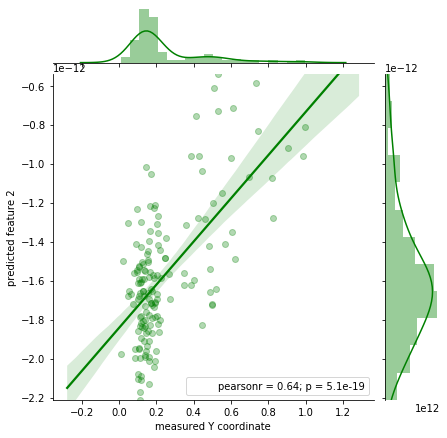

In [48]:
import seaborn as sns
import scipy.stats as stat

sns.jointplot(x = label[ex_neurons,1], y = yhat[ex_neurons,0], kind = 'reg', stat_func=stat.pearsonr, scatter_kws = {'alpha':0.3}, color = 'green')
plt.ylim(yhat[ex_neurons,0].min(), yhat[ex_neurons,0].max())
plt.xlabel('measured Y coordinate')
plt.ylabel('predicted feature 2')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


(-2.5065666e-12, 2.418335e-13)

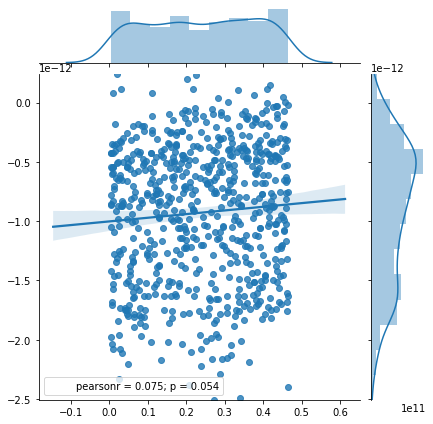

In [66]:
import seaborn as sns
import scipy.stats as stat

sns.jointplot(x = label[ex_neurons,0][0], y = yhat[ex_neurons,0][0], kind = 'reg', stat_func=stat.pearsonr)
plt.ylim(yhat[ex_neurons,0].min(), yhat[ex_neurons,0].max())

In [209]:
yhat[ex_neurons,0].min()

-2.211528e-12

[(0, 1)]

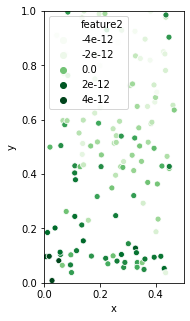

In [118]:
plt.figure(figsize=(2.5,5))
g = plot_genes(label[ex_neurons,:][0], yhat[ex_neurons,:][0], 'Greens', 2)

#plt.legend([],[], frameon=False)
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

In [120]:
df = pd.DataFrame(np.concatenate((celltype_labels[ex_neurons].reshape(len(celltype_labels[ex_neurons]), -1), yhat[ex_neurons,2][0].reshape(len(yhat[ex_neurons,2][0]),-1)), axis = 1))

In [56]:
df = pd.DataFrame(np.concatenate((celltype_labels.reshape(len(celltype_labels), -1), yhat[0:len(celltype_labels),0].reshape(len(yhat[0:len(celltype_labels),0]),-1)), axis=1))

In [121]:
df_wide=df.pivot(columns=0,values=1)

Text(0.5, 0, 'feature 2')

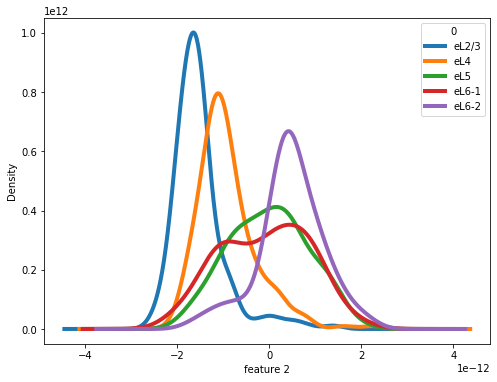

In [123]:
df_wide.plot.density(figsize=(8,6),linewidth=4)
plt.xlabel('feature 2')

In [87]:
celltype_labels[ex_neurons]

array(['eL6-2', 'eL4', 'eL2/3', 'eL6-2', 'eL5', 'eL6-1', 'eL6-1', 'eL6-2',
       'eL6-1', 'eL4', 'eL2/3', 'eL2/3', 'eL4', 'eL2/3', 'eL6-1', 'eL6-2',
       'eL5', 'eL4', 'eL6-2', 'eL4', 'eL2/3', 'eL2/3', 'eL5', 'eL4',
       'eL4', 'eL5', 'eL4', 'eL6-2', 'eL5', 'eL2/3', 'eL4', 'eL2/3',
       'eL2/3', 'eL6-2', 'eL2/3', 'eL6-2', 'eL4', 'eL6-2', 'eL5', 'eL4',
       'eL2/3', 'eL6-2', 'eL6-1', 'eL5', 'eL2/3', 'eL4', 'eL4', 'eL6-2',
       'eL4', 'eL6-2', 'eL5', 'eL4', 'eL6-2', 'eL4', 'eL2/3', 'eL2/3',
       'eL4', 'eL4', 'eL6-2', 'eL6-2', 'eL6-1', 'eL4', 'eL4', 'eL6-1',
       'eL6-1', 'eL2/3', 'eL4', 'eL2/3', 'eL6-2', 'eL6-1', 'eL5', 'eL5',
       'eL2/3', 'eL4', 'eL2/3', 'eL6-2', 'eL2/3', 'eL6-1', 'eL6-2',
       'eL2/3', 'eL5', 'eL6-1', 'eL5', 'eL6-2', 'eL6-1', 'eL6-1', 'eL6-1',
       'eL6-1', 'eL6-2', 'eL5', 'eL4', 'eL2/3', 'eL6-1', 'eL4', 'eL6-1',
       'eL6-2', 'eL6-1', 'eL6-2', 'eL5', 'eL2/3', 'eL5', 'eL4', 'eL2/3',
       'eL6-2', 'eL4', 'eL6-2', 'eL2/3', 'eL2/3', 'eL6-1', 'eL

[(0, 1)]

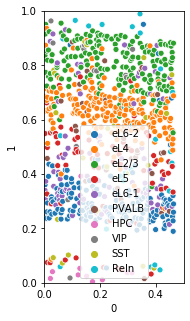

In [45]:
# plot cells to check 
plt.figure(figsize=(2.5,5))

#plt.legend([],[], frameon=False)



include = set(('Astro-1',
 'Astro-2',
 'Endo',
 'Micro',
 'Oligo',
 'Astro', 'Smc', 'Astro'))

subsetted_labels_neurons = [None if item in include else item for item in celltype_labels]
g = sns.scatterplot(data = pd.DataFrame(labels_subsetted), x = 0, y = 1, hue =subsetted_labels_neurons)
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))
#plt.legend([],[], frameon=False)


In [106]:

include = set(('Astro-1',
 'Astro-2',
 'Endo',
 'Micro',
 'Oligo',
 'Astro', 'Smc', 'Astro'))
subsetted_labels_neurons = [None if item in include else item for item in celltype_labels]

subsetted_labels_neurons

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'eL6-2',
 'eL4',
 nan,
 nan,
 'eL2/3',
 nan,
 'eL6-2',
 'eL5',
 'eL6-1',
 nan,
 nan,
 'eL6-1',
 'eL6-2',
 'eL6-1',
 None,
 'eL4',
 'eL2/3',
 'eL2/3',
 'eL4',
 'eL2/3',
 'eL6-1',
 None,
 None,
 nan,
 None,
 'eL6-2',
 'eL5',
 'eL4',
 'eL6-2',
 'eL4',
 nan,
 'eL2/3',
 None,
 'eL2/3',
 'eL5',
 'eL4',
 None,
 nan,
 'eL4',
 None,
 'eL5',
 'eL4',
 None,
 'eL6-2',
 'PVALB',
 'eL5',
 None,
 None,
 'eL2/3',
 nan,
 nan,
 'eL4',
 None,
 'eL2/3',
 None,
 'eL2/3',
 'eL6-2',
 nan,
 'eL2/3',
 None,
 None,
 'eL6-2',
 'eL4',
 None,
 nan,
 'eL6-2',
 nan,
 'eL5',
 'eL4',
 'eL2/3',
 'eL6-2',
 None,
 'eL6-1',
 None,
 nan,
 nan,
 'eL5',
 None,
 'HPC',
 'eL2/3',
 None,
 'VIP',
 nan,
 None,
 'eL4',
 'eL4',
 'eL6-2',
 'eL4',
 'eL6-2',
 nan,
 'eL5',
 'eL4',
 'eL6-2',
 'eL4',
 'eL2/3',
 None,
 'eL2/3',
 'eL4',
 'eL4',
 None,
 nan,
 'eL6-2',
 'HPC',
 nan,
 'eL6-2',
 'PVALB',
 'eL6-1',
 None,
 'eL4',
 'eL4',
 'VIP',
 nan,
 'eL6-1',
 None,
 'SST',
 'SST',
 'eL6-1',
 '

[(0, 1)]

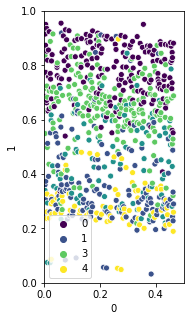

In [86]:
# color cells according to clusters 

# clustering on the predicted values recapitulates the layered structure 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(yhat[ex_neurons[0],:])

# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))
lab = pd.DataFrame(labels_subsetted)
lab = lab.loc[ex_neurons[0],:]
g = sns.scatterplot(data = lab, x = 0, y = 1, hue = kmeans.labels_, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

[(0, 1)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 4 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 1 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 0 missing from current font.
  font.

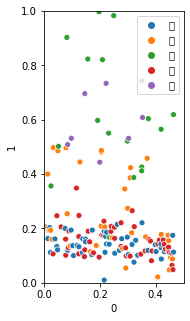

In [110]:
# color cells according to clusters 

# clustering on the predicted values recapitulates the layered structure 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(yhat[ex_neurons[0],:])

# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))
lab = pd.DataFrame(labels_subsetted)
lab = lab.loc[ex_neurons[0],:]
cols = [chr(item) for item in kmeans.labels_]
g = sns.scatterplot(data = lab, x = 0, y = 1, hue = cols)
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

In [109]:
 [chr(item) for item in kmeans.labels_]

['\x04',
 '\x03',
 '\x04',
 '\x03',
 '\x03',
 '\x04',
 '\x04',
 '\x03',
 '\x02',
 '\x03',
 '\x01',
 '\x03',
 '\x04',
 '\x04',
 '\x01',
 '\x04',
 '\x03',
 '\x02',
 '\x01',
 '\x04',
 '\x01',
 '\x01',
 '\x03',
 '\x02',
 '\x03',
 '\x00',
 '\x04',
 '\x01',
 '\x01',
 '\x03',
 '\x04',
 '\x00',
 '\x04',
 '\x04',
 '\x01',
 '\x04',
 '\x01',
 '\x01',
 '\x04',
 '\x01',
 '\x03',
 '\x04',
 '\x04',
 '\x01',
 '\x00',
 '\x01',
 '\x04',
 '\x04',
 '\x02',
 '\x01',
 '\x01',
 '\x03',
 '\x04',
 '\x04',
 '\x01',
 '\x03',
 '\x02',
 '\x01',
 '\x02',
 '\x00',
 '\x03',
 '\x03',
 '\x01',
 '\x03',
 '\x02',
 '\x01',
 '\x01',
 '\x04',
 '\x04',
 '\x03',
 '\x04',
 '\x04',
 '\x00',
 '\x04',
 '\x04',
 '\x02',
 '\x04',
 '\x02',
 '\x01',
 '\x01',
 '\x03',
 '\x02',
 '\x01',
 '\x01',
 '\x04',
 '\x04',
 '\x04',
 '\x01',
 '\x01',
 '\x04',
 '\x03',
 '\x03',
 '\x03',
 '\x01',
 '\x01',
 '\x02',
 '\x04',
 '\x03',
 '\x04',
 '\x00',
 '\x01',
 '\x03',
 '\x03',
 '\x04',
 '\x03',
 '\x01',
 '\x02',
 '\x04',
 '\x01',
 '\x04',
 '\x04',
 

[(0, 1)]

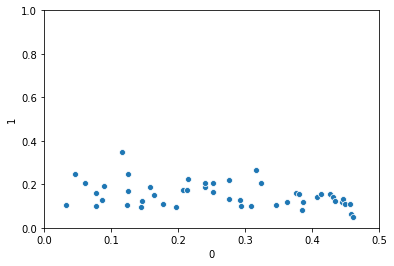

In [100]:
# how can we quantify if these clusters are really spatially separated based on the actual spatial values?

g = sns.scatterplot(data = lab.loc[kmeans.labels_==1,:], x = 0, y = 1, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))


[(0, 1)]

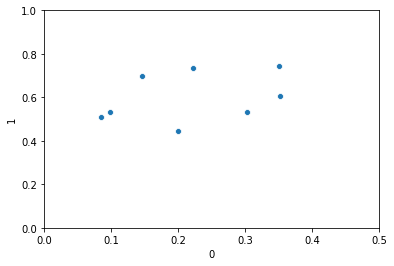

In [90]:
g = sns.scatterplot(data = lab.loc[kmeans.labels_==0,:], x = 0, y = 1, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

[(0, 1)]

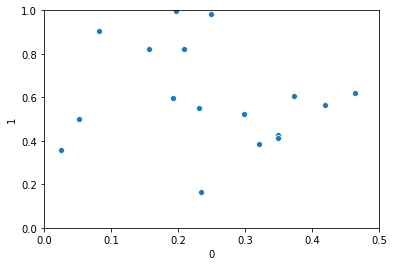

In [91]:
g = sns.scatterplot(data = lab.loc[kmeans.labels_==2,:], x = 0, y = 1, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

[(0, 1)]

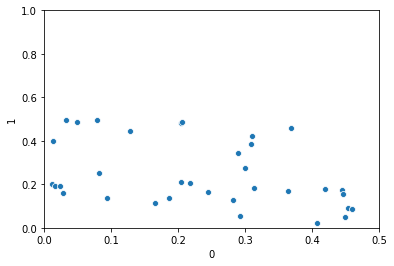

In [92]:
g = sns.scatterplot(data = lab.loc[kmeans.labels_==3,:], x = 0, y = 1, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

[(0, 1)]

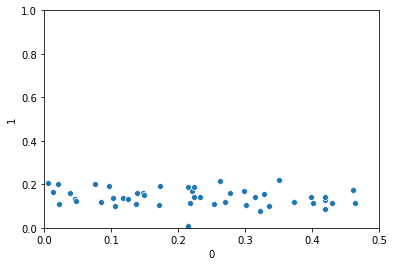

In [93]:
g = sns.scatterplot(data = lab.loc[kmeans.labels_==4,:], x = 0, y = 1, palette='viridis')
g.set(xlim=(0, .5))
g.set(ylim=(0, 1))

In [65]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(yhat[ex_neurons[0],:])

# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plt.figure(figsize=(2.5,5))
lab = pd.DataFrame(label)
lab = lab.loc[ex_neurons[0],:]

<Figure size 180x360 with 0 Axes>

In [107]:
lab

,0,1,2
30,0.006470,0.206569,0.0
50,0.012892,0.400158,0.0
54,0.013618,0.162747,0.0
55,0.012579,0.203716,0.0
68,0.017033,0.193426,0.0
71,0.020432,0.202960,0.0
85,0.022618,0.111636,0.0
88,0.023523,0.193309,0.0
91,0.024763,0.356379,0.0
107,0.028201,0.160354,0.0


In [55]:
kmeans.labels_[ex_neurons[0]]

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       3, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 3, 3, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 3, 2, 2, 0, 2, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
      dtype=int32)